In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = list(stopwords.words('english'))

import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, RobertaForSequenceClassification
import torch.optim as optim
from torch.optim import SGD, RMSprop, AdamW

from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
df = pd.read_csv('/content/gdrive/My Drive/cleaned_model_data.csv',encoding='ISO-8859-1')

In [6]:
df.head()

,Unnamed: 0,target,tweet_text,original_text_length,current_tweet_len
0,0,0,awww that bummer you shoulda got david carr of...,115,65
1,1,0,is upset that he can update his facebook by te...,111,101
2,2,0,dived many times for the ball managed to save ...,89,71
3,3,0,my whole body feels itchy and like its on fire,47,46
4,4,0,no it not behaving at all mad why am here beca...,111,76


In [7]:
df['tweet_text_sw'] = df['tweet_text']
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [9]:
subset_df = pd.concat([df.head(110000), df.iloc[-110000:]])
subset_df = subset_df.sample(frac=1).reset_index(drop=True)
subset_df.target.value_counts()

4    110000
0    110000
Name: target, dtype: int64

In [10]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english") # more aggressive than Porter Stemmer

def lemmatize_and_stem_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        lemmatized_word = lemmatizer.lemmatize(w)
        stemmed_word = stemmer.stem(lemmatized_word)
        st = st + stemmed_word + " "
    return st

subset_df['tweet_text'] = subset_df.tweet_text.apply(lemmatize_and_stem_text)

## Moving onto pre-trained BERT model

#### Bidirectional Encoder Representations from Transformers

In [11]:
from sklearn.model_selection import train_test_split

# train, val, and test subsets
train_df, test_df = train_test_split(subset_df, test_size=0.1, stratify = subset_df['target'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify = train_df['target'], random_state=42)

# shuffling train set again
train_df = train_df.sample(frac=1, random_state=42)

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', # trained on lowercase english texts, basic form of BERT
    do_lower_case = True # to ensure text passed to model is in lowercase
    )

# tokenize train, val, test :
train_encoded_data = tokenizer.batch_encode_plus(
    train_df['tweet_text'].tolist(),
    add_special_tokens=True, # BERT requires special tokens at the beginning and end.
    return_attention_mask=True, # helps model differentiate between actual content and padding
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt' # pytorch tensors
)

val_encoded_data = tokenizer.batch_encode_plus(
    val_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

test_encoded_data = tokenizer.batch_encode_plus(
    test_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

# defined input_ids, attention_masks, and labels
train_input_ids = train_encoded_data['input_ids'] # numerical representation of tweets
train_attention_masks = train_encoded_data['attention_mask'] 
train_labels = torch.tensor(train_df['target'].replace(4, 1).tolist()) # converts the list to Pytorch tensor

val_input_ids = val_encoded_data['input_ids']
val_attention_masks = val_encoded_data['attention_mask']
val_labels = torch.tensor(val_df['target'].replace(4, 1).tolist()) 

test_input_ids = test_encoded_data['input_ids']
test_attention_masks = test_encoded_data['attention_mask']
test_labels = torch.tensor(test_df['target'].replace(4, 1).tolist())

# dataloader instances (efficiently feed data in batches to model during training)
batch_size = 40
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# del model_adamw
# torch.cuda.empty_cache() 

## BERT with SGD : 

In [13]:
# BERT model
model_bert_SGD = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert_SGD.to(device) 

optimizer = optim.SGD(model_bert_SGD.parameters(), lr=0.01)

# number of epochs
epochs = 3
# storing acc after every epoch
accuracies_sgd = []  
# storing acc after every 500 batch
batch_accuracies_sgd = []    

for epoch in range(epochs):
    model_bert_SGD.train()
    total_loss = 0
    for i, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad() # clear accumulated gradient
        outputs = model_bert_SGD(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 100 == 0:
            avg_train_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Train Loss: {avg_train_loss:.4f}")

        if i % 500 == 0:
            model.eval()
            val_accuracy = 0
            val_total = 0
            with torch.no_grad():
                for val_batch in val_dataloader:
                    val_batch = tuple(t.to(device) for t in val_batch)
                    val_input_ids, val_input_mask, val_labels = val_batch

                    val_outputs = model(val_input_ids, attention_mask=val_input_mask)
                    val_logits = val_outputs.logits
                    val_predictions = torch.argmax(val_logits, dim=1)

                    val_accuracy += (val_predictions == val_labels).sum().item()
                    val_total += val_labels.size(0)

            batch_val_accuracy = val_accuracy / val_total
            batch_accuracies_sgd.append(batch_val_accuracy)
            print(f"Batch {i}, Validation Accuracy (500 batches): {batch_val_accuracy:.4f}")
            model.train()

    model.eval()
    val_accuracy = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_accuracy += (predictions == b_labels).sum().item()
            val_total += b_labels.size(0)

    epoch_val_accuracy = val_accuracy / val_total
    accuracies_sgd.append(epoch_val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_dataloader):.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Batch 100/3960, Train Loss: 0.6924
Epoch 1/3, Batch 200/3960, Train Loss: 0.6587
Epoch 1/3, Batch 300/3960, Train Loss: 0.6320
Epoch 1/3, Batch 400/3960, Train Loss: 0.6172
Epoch 1/3, Batch 500/3960, Train Loss: 0.6032
Batch 500, Validation Accuracy (500 batches): 0.7245
Epoch 1/3, Batch 600/3960, Train Loss: 0.5940
Epoch 1/3, Batch 700/3960, Train Loss: 0.5855
Epoch 1/3, Batch 800/3960, Train Loss: 0.5795
Epoch 1/3, Batch 900/3960, Train Loss: 0.5745
Epoch 1/3, Batch 1000/3960, Train Loss: 0.5694
Batch 1000, Validation Accuracy (500 batches): 0.7499
Epoch 1/3, Batch 1100/3960, Train Loss: 0.5650
Epoch 1/3, Batch 1200/3960, Train Loss: 0.5632
Epoch 1/3, Batch 1300/3960, Train Loss: 0.5606
Epoch 1/3, Batch 1400/3960, Train Loss: 0.5567
Epoch 1/3, Batch 1500/3960, Train Loss: 0.5546
Batch 1500, Validation Accuracy (500 batches): 0.7508
Epoch 1/3, Batch 1600/3960, Train Loss: 0.5523
Epoch 1/3, Batch 1700/3960, Train Loss: 0.5496
Epoch 1/3, Batch 1800/3960, Train Loss: 0.5471
Ep

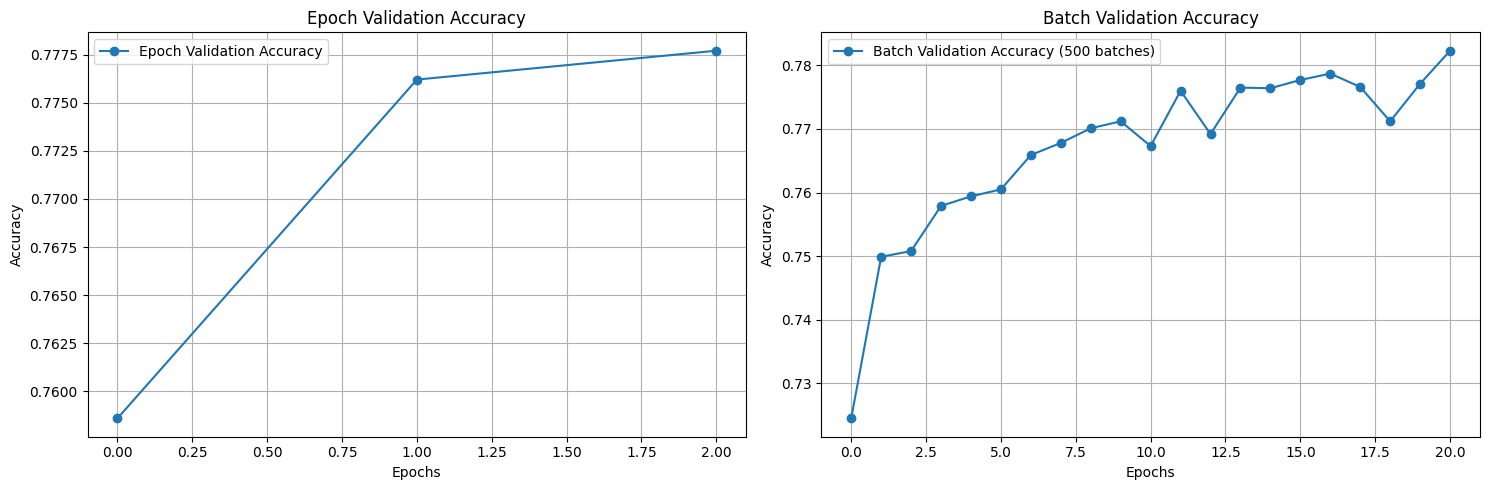

In [21]:
# save accuracy lists to local system
# with open('epoch_accuracies_sgd.txt', 'w') as f:
#     for item in accuracies_sgd:
#         f.write(f"{item:.4f}\n")

# with open('batch_accuracies_sgd.txt', 'w') as f:
#     for item in batch_accuracies_sgd:
#         f.write(f"{item:.4f}\n")

# plot accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# epoch val acc
ax1.plot(accuracies_sgd, label='Epoch Validation Accuracy', marker='o')
ax1.set_title('Epoch Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# batch val acc during training
ax2.plot(batch_accuracies_sgd, label='Batch Validation Accuracy (500 batches)', marker='o')
ax2.set_title('Batch Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

## BERT with AdamW ( Adaptive Moment Estimation): 

In [11]:
model_adamw = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# setting up GPU to utilize google colab's GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw.to(device)
optimizer_adamw = AdamW(model_adamw.parameters(), lr=2e-5, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
epochs = 3
# preserve accuracies
accuracies_adamw = []          
batch_accuracies_adamw = []

for epoch in range(epochs):
    model_adamw.train()
    total_loss = 0

    # training loop
    for i, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model_adamw(**inputs)
        loss = outputs[0]
        loss.backward()
        optimizer_adamw.step()
        optimizer_adamw.zero_grad()

        # progress every 100 batches
        if i % 100 == 0:
            avg_train_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Train Loss: {avg_train_loss:.4f}")

        # val acc every 500 batches
        if i % 500 == 0:
            model_adamw.eval()
            val_accuracy_batch = 0
            predictions_batch, true_vals_batch = [], []
            for batch in val_dataloader:
                batch = tuple(b.to(device) for b in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                with torch.no_grad():
                    outputs = model_adamw(**inputs)
                logits = outputs[1]
                logits = logits.detach().cpu().numpy()
                predictions_batch.append(np.argmax(logits, axis=1))
                true_vals_batch.append(inputs['labels'].cpu().numpy())

            predictions_batch = np.concatenate(predictions_batch, axis=0)
            true_vals_batch = np.concatenate(true_vals_batch, axis=0)
            val_accuracy_batch = np.mean(predictions_batch == true_vals_batch)
            batch_accuracies_adamw.append(val_accuracy_batch)
            
            # val accuracy
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Validation Accuracy: {val_accuracy_batch:.4f}")
            model_adamw.train()

    # acc at each epoch
    model_adamw.eval()
    val_accuracy = 0
    predictions, true_vals = [], []
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        with torch.no_grad():
            outputs = model_adamw(**inputs)
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        predictions.append(np.argmax(logits, axis=1))
        true_vals.append(inputs['labels'].cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    val_accuracy = np.mean(predictions == true_vals)
    accuracies_adamw.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/3, Batch 0/3960, Train Loss: 0.6899
Epoch 1/3, Batch 0/3960, Validation Accuracy: 0.4997
Epoch 1/3, Batch 100/3960, Train Loss: 0.6746
Epoch 1/3, Batch 200/3960, Train Loss: 0.6209
Epoch 1/3, Batch 300/3960, Train Loss: 0.5906
Epoch 1/3, Batch 400/3960, Train Loss: 0.5776
Epoch 1/3, Batch 500/3960, Train Loss: 0.5664
Epoch 1/3, Batch 500/3960, Validation Accuracy: 0.7529
Epoch 1/3, Batch 600/3960, Train Loss: 0.5572
Epoch 1/3, Batch 700/3960, Train Loss: 0.5506
Epoch 1/3, Batch 800/3960, Train Loss: 0.5454
Epoch 1/3, Batch 900/3960, Train Loss: 0.5412
Epoch 1/3, Batch 1000/3960, Train Loss: 0.5361
Epoch 1/3, Batch 1000/3960, Validation Accuracy: 0.7639
Epoch 1/3, Batch 1100/3960, Train Loss: 0.5329
Epoch 1/3, Batch 1200/3960, Train Loss: 0.5303
Epoch 1/3, Batch 1300/3960, Train Loss: 0.5278
Epoch 1/3, Batch 1400/3960, Train Loss: 0.5251
Epoch 1/3, Batch 1500/3960, Train Loss: 0.5228
Epoch 1/3, Batch 1500/3960, Validation Accuracy: 0.7599
Epoch 1/3, Batch 1600/3960, Train Loss: 

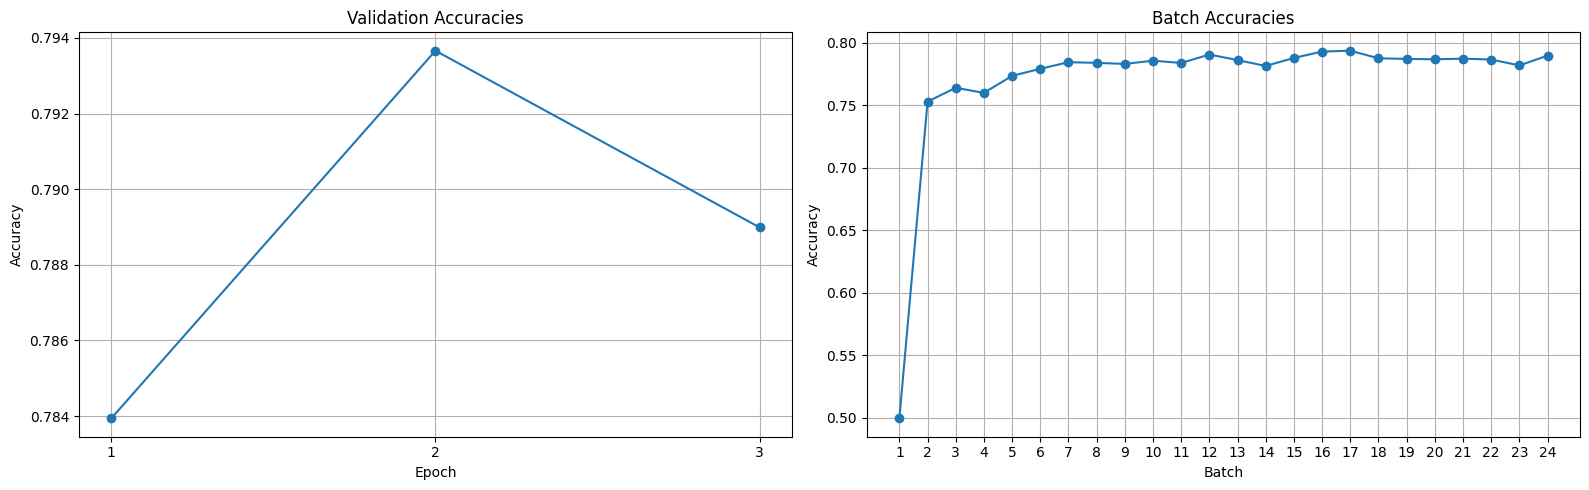

In [26]:
# save accuracies to local files
with open('accuracies_adamw.pkl', 'wb') as f:
    pickle.dump(accuracies_adamw, f)

with open('batch_accuracies_adamw.pkl', 'wb') as f:
    pickle.dump(batch_accuracies_adamw, f) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# val acc
ax1.plot(range(1, len(accuracies_adamw) + 1), accuracies_adamw, marker='o')
ax1.set_title('Validation Accuracies')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(1, len(accuracies_adamw) + 1))
ax1.grid(True)

# batch acc during training
ax2.plot(range(1, len(batch_accuracies_adamw) + 1), batch_accuracies_adamw, marker='o')
ax2.set_title('Batch Accuracies')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(range(1, len(batch_accuracies_adamw) + 1))
ax2.grid(True)

plt.tight_layout()
plt.show()

In [1]:
# torch.save(model_adamw, 'model.pth')

In [22]:
# torch.save(model, 'model.pth')

## RoBERTa :  

In [23]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encoded_data = tokenizer.batch_encode_plus(
    train_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

val_encoded_data = tokenizer.batch_encode_plus(
    val_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

test_encoded_data = tokenizer.batch_encode_plus(
    test_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

train_input_ids = train_encoded_data['input_ids']
train_attention_masks = train_encoded_data['attention_mask']
train_labels = torch.tensor(train_df['target'].replace(4, 1).tolist())

val_input_ids = val_encoded_data['input_ids']
val_attention_masks = val_encoded_data['attention_mask']
val_labels = torch.tensor(val_df['target'].replace(4, 1).tolist())

test_input_ids = test_encoded_data['input_ids']
test_attention_masks = test_encoded_data['attention_mask']
test_labels = torch.tensor(test_df['target'].replace(4, 1).tolist())

batch_size = 40
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
model_rob = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rob.to(device)

# optimizer (SGD) and learning rate
optimizer = optim.SGD(model_rob.parameters(), lr=0.01)  # Adjust the learning rate as needed

batch_accuracies = []
val_accuracies = []

epochs = 3
for epoch in range(epochs):
    model_rob.train()
    total_loss = 0
    for i, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch

        optimizer.zero_grad()
        outputs = model_rob(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 100 == 0:
            avg_train_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Train Loss: {avg_train_loss:.4f}")

        if i % 500 == 0:
            model_rob.eval()
            batch_accuracy = 0
            batch_total = 0
            with torch.no_grad():
                for batch_val in train_dataloader:  # Use train dataloader for batch accuracy
                    batch_val = tuple(t.to(device) for t in batch_val)
                    val_input_ids, val_attention_masks, val_labels = batch_val

                    val_outputs = model_rob(val_input_ids, attention_mask=val_attention_masks)
                    val_logits = val_outputs.logits
                    val_predictions = torch.argmax(val_logits, dim=1)

                    batch_accuracy += (val_predictions == val_labels).sum().item()
                    batch_total += val_labels.size(0)

            epoch_batch_accuracy = batch_accuracy / batch_total
            batch_accuracies.append(epoch_batch_accuracy)
            model_rob.train()

    model_rob.eval()
    val_accuracy = 0
    val_total = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = tuple(t.to(device) for t in val_batch)
            val_input_ids, val_attention_masks, val_labels = val_batch

            val_outputs = model_rob(val_input_ids, attention_mask=val_attention_masks)
            val_logits = val_outputs.logits
            val_predictions = torch.argmax(val_logits, dim=1)

            val_accuracy += (val_predictions == val_labels).sum().item()
            val_total += val_labels.size(0)

    epoch_val_accuracy = val_accuracy / val_total
    val_accuracies.append(epoch_val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_dataloader):.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Batch 100/3960, Train Loss: 0.6887
Epoch 1/3, Batch 200/3960, Train Loss: 0.6871
Epoch 1/3, Batch 300/3960, Train Loss: 0.6836
Epoch 1/3, Batch 400/3960, Train Loss: 0.6734
Epoch 1/3, Batch 500/3960, Train Loss: 0.6596
Epoch 1/3, Batch 600/3960, Train Loss: 0.6518
Epoch 1/3, Batch 700/3960, Train Loss: 0.6431
Epoch 1/3, Batch 800/3960, Train Loss: 0.6357
Epoch 1/3, Batch 900/3960, Train Loss: 0.6281
Epoch 1/3, Batch 1000/3960, Train Loss: 0.6232
Epoch 1/3, Batch 1100/3960, Train Loss: 0.6187
Epoch 1/3, Batch 1200/3960, Train Loss: 0.6149
Epoch 1/3, Batch 1300/3960, Train Loss: 0.6106
Epoch 1/3, Batch 1400/3960, Train Loss: 0.6058
Epoch 1/3, Batch 1500/3960, Train Loss: 0.6021
Epoch 1/3, Batch 1600/3960, Train Loss: 0.5999
Epoch 1/3, Batch 1700/3960, Train Loss: 0.6001
Epoch 1/3, Batch 1800/3960, Train Loss: 0.5972
Epoch 1/3, Batch 1900/3960, Train Loss: 0.5939
Epoch 1/3, Batch 2000/3960, Train Loss: 0.5908
Epoch 1/3, Batch 2100/3960, Train Loss: 0.5882
Epoch 1/3, Batch 2200/

In [26]:
# torch.save(model_rob, 'model_robert.pth')

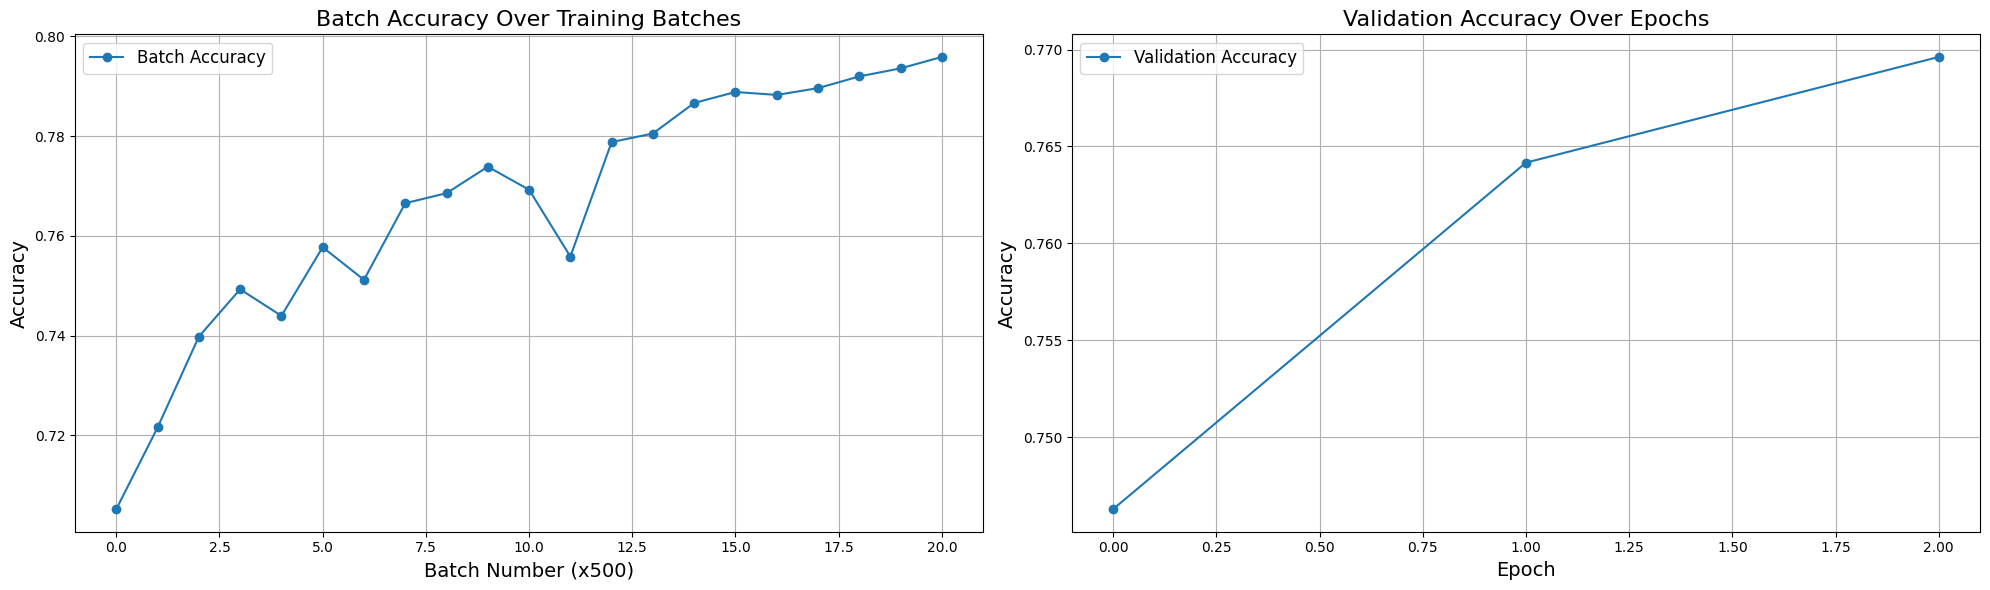

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot batch acc
ax1.plot(batch_accuracies_robert, label='Batch Accuracy', marker='o')
ax1.set_title('Batch Accuracy Over Training Batches', fontsize=16)
ax1.set_xlabel('Batch Number (x500)', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True)

# plot val acc
ax2.plot(accuracies_robert, label='Validation Accuracy', marker='o')
ax2.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

# Save accuracies to text files
# with open('batch_accuracies_robert.txt', 'w') as f:
#     for acc in batch_accuracies:
#         f.write(f'{acc}\n')

# with open('val_accuracies_robert.txt', 'w') as f:
#     for acc in val_accuracies:
#         f.write(f'{acc}\n')

### Read all the accuracies from local system : 

In [8]:
import pickle

with open('/Users/alenjose/Desktop/project_data/accuracies_adamw.pkl', 'rb') as f:
    accuracies_adamw = pickle.load(f)

with open('/Users/alenjose/Desktop/project_data/batch_accuracies_adamw.pkl', 'rb') as f:
    batch_accuracies_adamw = pickle.load(f)
    
with open('/Users/alenjose/Desktop/project_data/epoch_accuracies_sgd.txt', 'r') as f:
    accuracies_sgd = [float(line.strip()) for line in f.readlines()]

with open('/Users/alenjose/Desktop/project_data/batch_accuracies_sgd.txt', 'r') as f:
    batch_accuracies_sgd = [float(line.strip()) for line in f.readlines()]
    
with open('/Users/alenjose/Desktop/project_data/batch_accuracies_robert.txt', 'r') as f:
    batch_accuracies_robert = [float(line.strip()) for line in f.readlines()]

with open('/Users/alenjose/Desktop/project_data/val_accuracies_robert.txt', 'r') as f:
    accuracies_robert = [float(line.strip()) for line in f.readlines()] 

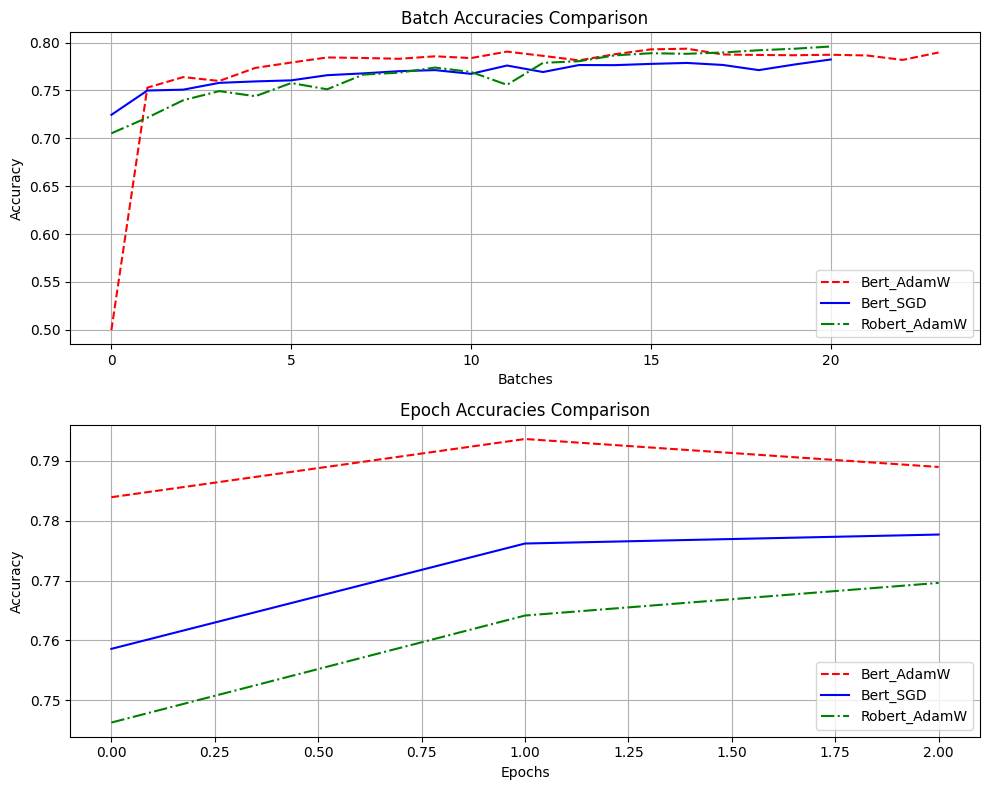

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # Change to 2 rows, 1 column

# batch accuracies
ax1.plot(batch_accuracies_adamw, label='Bert_AdamW', color='red', linestyle='--')
ax1.plot(batch_accuracies_sgd, label='Bert_SGD', color='blue', linestyle='-')
ax1.plot(batch_accuracies_robert, label='Robert_AdamW', color='green', linestyle='-.')
ax1.set_title('Batch Accuracies Comparison')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# epoch accuracies
ax2.plot(accuracies_adamw, label='Bert_AdamW', color='red', linestyle='--')
ax2.plot(accuracies_sgd, label='Bert_SGD', color='blue', linestyle='-')
ax2.plot(accuracies_robert, label='Robert_AdamW', color='green', linestyle='-.')
ax2.set_title('Epoch Accuracies Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

I decided to train the roberta model from above to new unseen data and see if the accuracy would go up. 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/cleaned_model_data.csv',encoding='ISO-8859-1')

In [ ]:
df['tweet_text_sw'] = df['tweet_text']
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
subset_df = pd.concat([df.head(110000), df.iloc[-110000:]])
subset_df = subset_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# preprocess and tokenize the new tweets
half_len = len(df) // 2
neg_df = df.iloc[:half_len]
pos_df = df.iloc[half_len:]

# exclude tweets already used
neg_df_remaining = neg_df.drop(subset_df.index, errors='ignore')
pos_df_remaining = pos_df.drop(subset_df.index, errors='ignore')

# sample 50,000 from each of the remaining negative and positive tweets
sampled_neg = neg_df_remaining.sample(50000, random_state=42)
sampled_pos = pos_df_remaining.sample(50000, random_state=42)

# concat the two samples together
subset_df = pd.concat([sampled_neg, sampled_pos]).sample(frac=1, random_state=42).reset_index(drop=True)
subset_df.target.value_counts()

In [ ]:
subset_df['tweet_text'] = subset_df.tweet_text.apply(lemmatize_and_stem_text)

In [ ]:
from sklearn.model_selection import train_test_split

# train, val, and test subsets
train_df, test_df = train_test_split(subset_df, test_size=0.1, stratify=subset_df['target'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['target'], random_state=42)

# shuffling train set again
train_df = train_df.sample(frac=1, random_state=42)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# tokenize datasets
train_encoded_data = tokenizer.batch_encode_plus(
    train_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

val_encoded_data = tokenizer.batch_encode_plus(
    val_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

test_encoded_data = tokenizer.batch_encode_plus(
    test_df['tweet_text'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=137,
    return_tensors='pt'
)

# prepare input_ids, attention_masks, and labels
train_input_ids = train_encoded_data['input_ids']
train_attention_masks = train_encoded_data['attention_mask']
train_labels = torch.tensor(train_df['target'].replace(4, 1).tolist())

val_input_ids = val_encoded_data['input_ids']
val_attention_masks = val_encoded_data['attention_mask']
val_labels = torch.tensor(val_df['target'].replace(4, 1).tolist())

test_input_ids = test_encoded_data['input_ids']
test_attention_masks = test_encoded_data['attention_mask']
test_labels = torch.tensor(test_df['target'].replace(4, 1).tolist())

# create dataloader instances
batch_size = 40
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
uploaded = files.upload() 
model_rob = torch.load('model_robert.pth')

# define optimizer (SGD) and learning rate
optimizer = optim.SGD(model_rob.parameters(), lr=0.01)  

batch_accuracies = []
val_accuracies = []

# training loop
epochs = 3
for epoch in range(epochs):
    model_rob.train()
    total_loss = 0
    for i, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch

        optimizer.zero_grad()
        outputs = model_rob(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # training loss progress every 100 batches
        if i % 100 == 0:
            avg_train_loss = total_loss / (i + 1)
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Train Loss: {avg_train_loss:.4f}")

        # 500 batches
        if i % 500 == 0:
            model_rob.eval()
            batch_accuracy = 0
            batch_total = 0
            with torch.no_grad():
                for batch_val in train_dataloader:  
                    batch_val = tuple(t.to(device) for t in batch_val)
                    val_input_ids, val_attention_masks, val_labels = batch_val

                    val_outputs = model_rob(val_input_ids, attention_mask=val_attention_masks)
                    val_logits = val_outputs.logits
                    val_predictions = torch.argmax(val_logits, dim=1)

                    batch_accuracy += (val_predictions == val_labels).sum().item()
                    batch_total += val_labels.size(0)

            epoch_batch_accuracy = batch_accuracy / batch_total
            batch_accuracies.append(epoch_batch_accuracy)
            model_rob.train()

    # val at each epoch
    model_rob.eval()
    val_accuracy = 0
    val_total = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = tuple(t.to(device) for t in val_batch)
            val_input_ids, val_attention_masks, val_labels = val_batch

            val_outputs = model_rob(val_input_ids, attention_mask=val_attention_masks)
            val_logits = val_outputs.logits
            val_predictions = torch.argmax(val_logits, dim=1)

            val_accuracy += (val_predictions == val_labels).sum().item()
            val_total += val_labels.size(0)

    epoch_val_accuracy = val_accuracy / val_total
    val_accuracies.append(epoch_val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_dataloader):.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

In [28]:
with open('/Users/alenjose/Desktop/project_data/batch_accuracies_robert_2.txt', 'r') as f:
    batch_accuracies_robert_2 = [float(line.strip()) for line in f.readlines()]

with open('/Users/alenjose/Desktop/project_data/val_accuracies_robert_2.txt', 'r') as f:
    accuracies_robert_2 = [float(line.strip()) for line in f.readlines()]

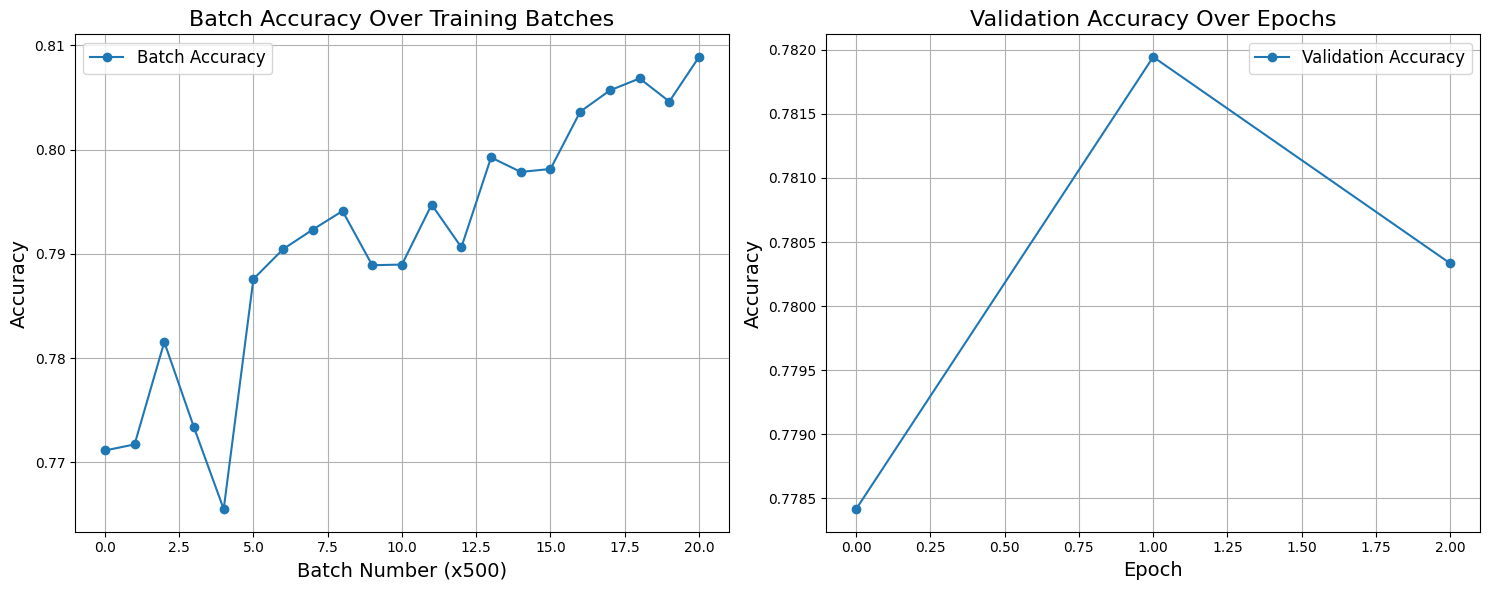

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# batch accuracies
ax1.plot(batch_accuracies_robert_2, label='Batch Accuracy', marker='o')
ax1.set_title('Batch Accuracy Over Training Batches', fontsize=16)
ax1.set_xlabel('Batch Number (x500)', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True)

# validation accuracies
ax2.plot(accuracies_robert_2, label='Validation Accuracy', marker='o')
ax2.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()